# Walmart : Triptype Classification

<img src="data/walmart.jpg">

# [ Overview ]

### (1) Objective : 
> ### 각 고객의 구매정보에 따른 구매 건의 Type을 분류

### (2) Data : 
### train : 647054 rows, 7 columns
| Index 	| Feature               	| Description                                  	|
|-------	|-----------------------	|----------------------------------------------	|
| 1     	| TripType              	| Target                                       	|
| 2     	| VisitNumber           	| 각 손님의 Index                              	|
| 3     	| Weekday               	| VisitNumber가 발생한 요일                    	|
| 4     	| Upc                   	| 구매한 제품의 고유한 바코드                  	|
| 5     	| ScanCount             	| 구매 수량 ( 반품 시 `-` 값으로 표기 )        	|
| 6     	| DepartmentDescription 	| 제품의 대분류                                	|
| 7     	| FinelineNumber        	| 월마트 자체적으로 정의 한 제품의 소분류 코드 	|

(3) _UPC code description_
- Check Digit : 숫자가 정확하게 구성되어 있는가를 보장해주는 컴퓨터 검증 숫자. UPC의 신뢰도를 검증

<img src="data/upc.png">



<br>

### test : 653646 rows, 6 columns
- 타겟값 TripType을 제외한 동일한 특성의 컬럼


<br>

### (3) Evaluation : 
> ### Multi-class log loss
> $$-\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij})$$

# [ Result ]: 
> #### - 참가 팀 : 총 1047 팀 
> #### - 최종 점수 : 0.779
> #### - 캐글 등수 : 293등 (상위 28%)


# [ Approach ]:
> #### - 주어진 컬럼을 통한 Feature Engineering
    - UPC decoding
    - ScanCount seperation
    - Feature encoding
    - Dummy variables
    - Identifing the most frequently purchased items per VisitNumber
    
> #### - XGBoost

* * * *

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from walmart_utils import *

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# [ EDA ]

In [5]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [7]:
train.describe()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,647054.000000,647054.000000,6.429250e+05,647054.000000,642925.000000
mean,58.584511,96167.640078,3.060698e+10,1.108878,3726.884567
std,157.635533,55545.485154,9.120134e+10,0.700776,2780.966158
min,3.000000,5.000000,8.340000e+02,-12.000000,0.000000
25%,27.000000,49268.000000,3.400001e+09,1.000000,1404.000000
50%,39.000000,97074.000000,7.050103e+09,1.000000,3352.000000
75%,40.000000,144316.000000,3.006531e+10,1.000000,5501.000000
max,999.000000,191347.000000,9.789707e+11,71.000000,9998.000000


## Train Data

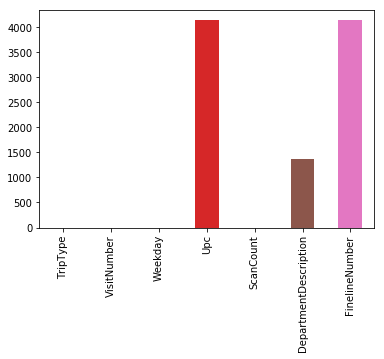

In [8]:
train.isnull().sum().plot(kind='bar')

- ### TripType의 출현이 균등하게 분배되지 않음.

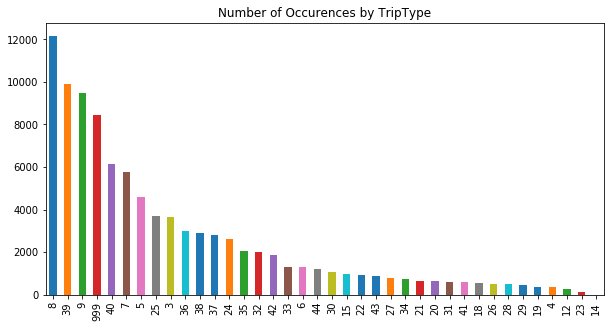

In [9]:
np.sort(train.TripType.unique())
train_triptypes = train.drop_duplicates("VisitNumber")
a = train_triptypes["TripType"]
a = a.value_counts()

graph = a.plot(kind='bar', figsize=(10, 5))
graph.set_title("Number of Occurences by TripType")
plt.show()

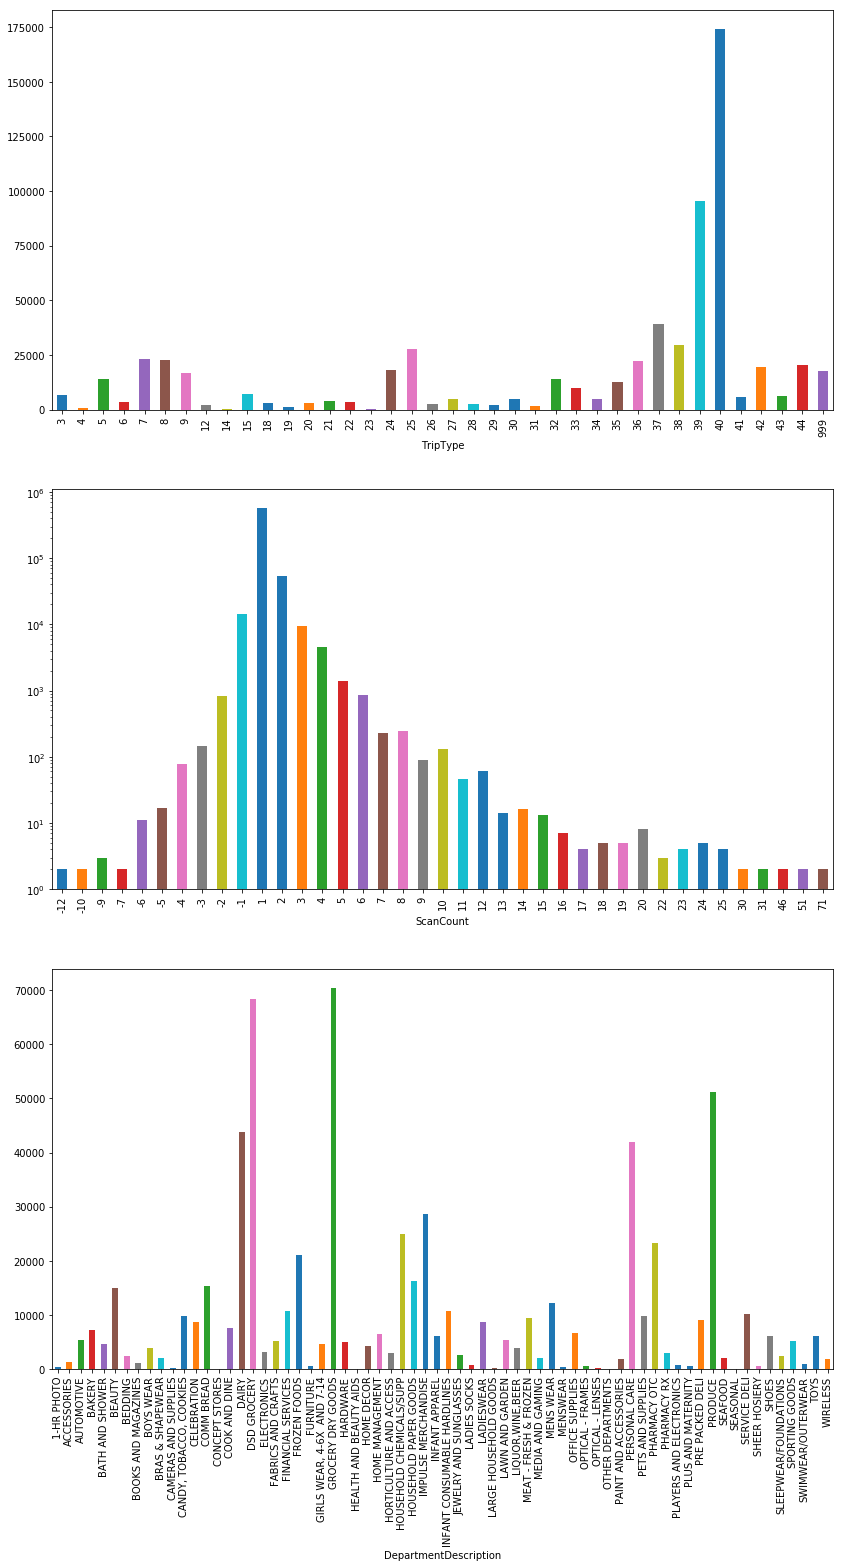

In [10]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(14, 25))

# Plot total number of TripTypes
ax1 = fig.add_subplot(311)
train.groupby(['TripType'], as_index=False).size().plot('bar')

# Plot total number of ScanCounts
ax2 = fig.add_subplot(312)
train.groupby(['ScanCount'], as_index=False).size().plot('bar', log=True)

# Plot total number of DepartmentDescriptions
ax3 = fig.add_subplot(313)
train.groupby(['DepartmentDescription'], as_index=False).size().plot('bar')

plt.show()

### Most frequent DepartmentDescription

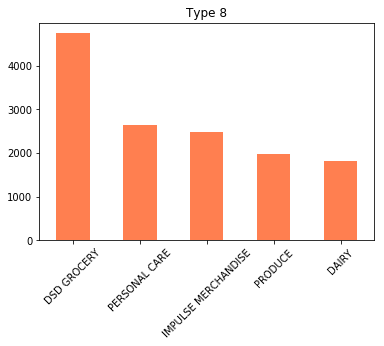

In [12]:
type_8 = train[train.TripType == 8]
type_8_items = type_8[["TripType","DepartmentDescription"]]
type_8_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                        title="Type 8", color="coral")
plt.xticks(fontsize=10)
plt.show()

### Most Frequent TripType

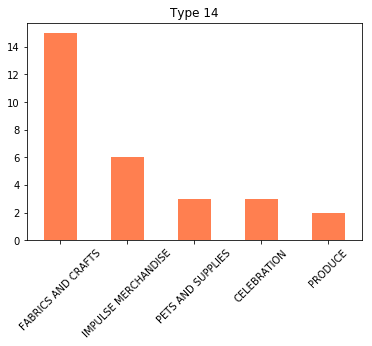

In [13]:
type_14 = train[train.TripType == 14]
type_14_items = type_14[["TripType","DepartmentDescription"]]
type_14_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                        title="Type 14", color="coral")
plt.xticks(fontsize=10)
plt.show()

### Most Frequent Weekday

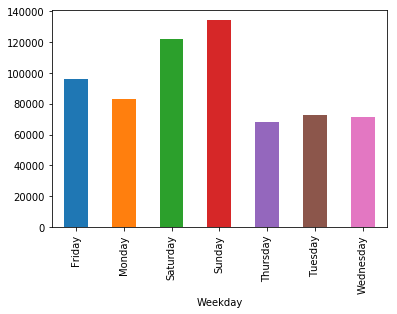

In [14]:
# Plot total number of Weekday
train.groupby(['Weekday']).size().plot('bar')
plt.show()

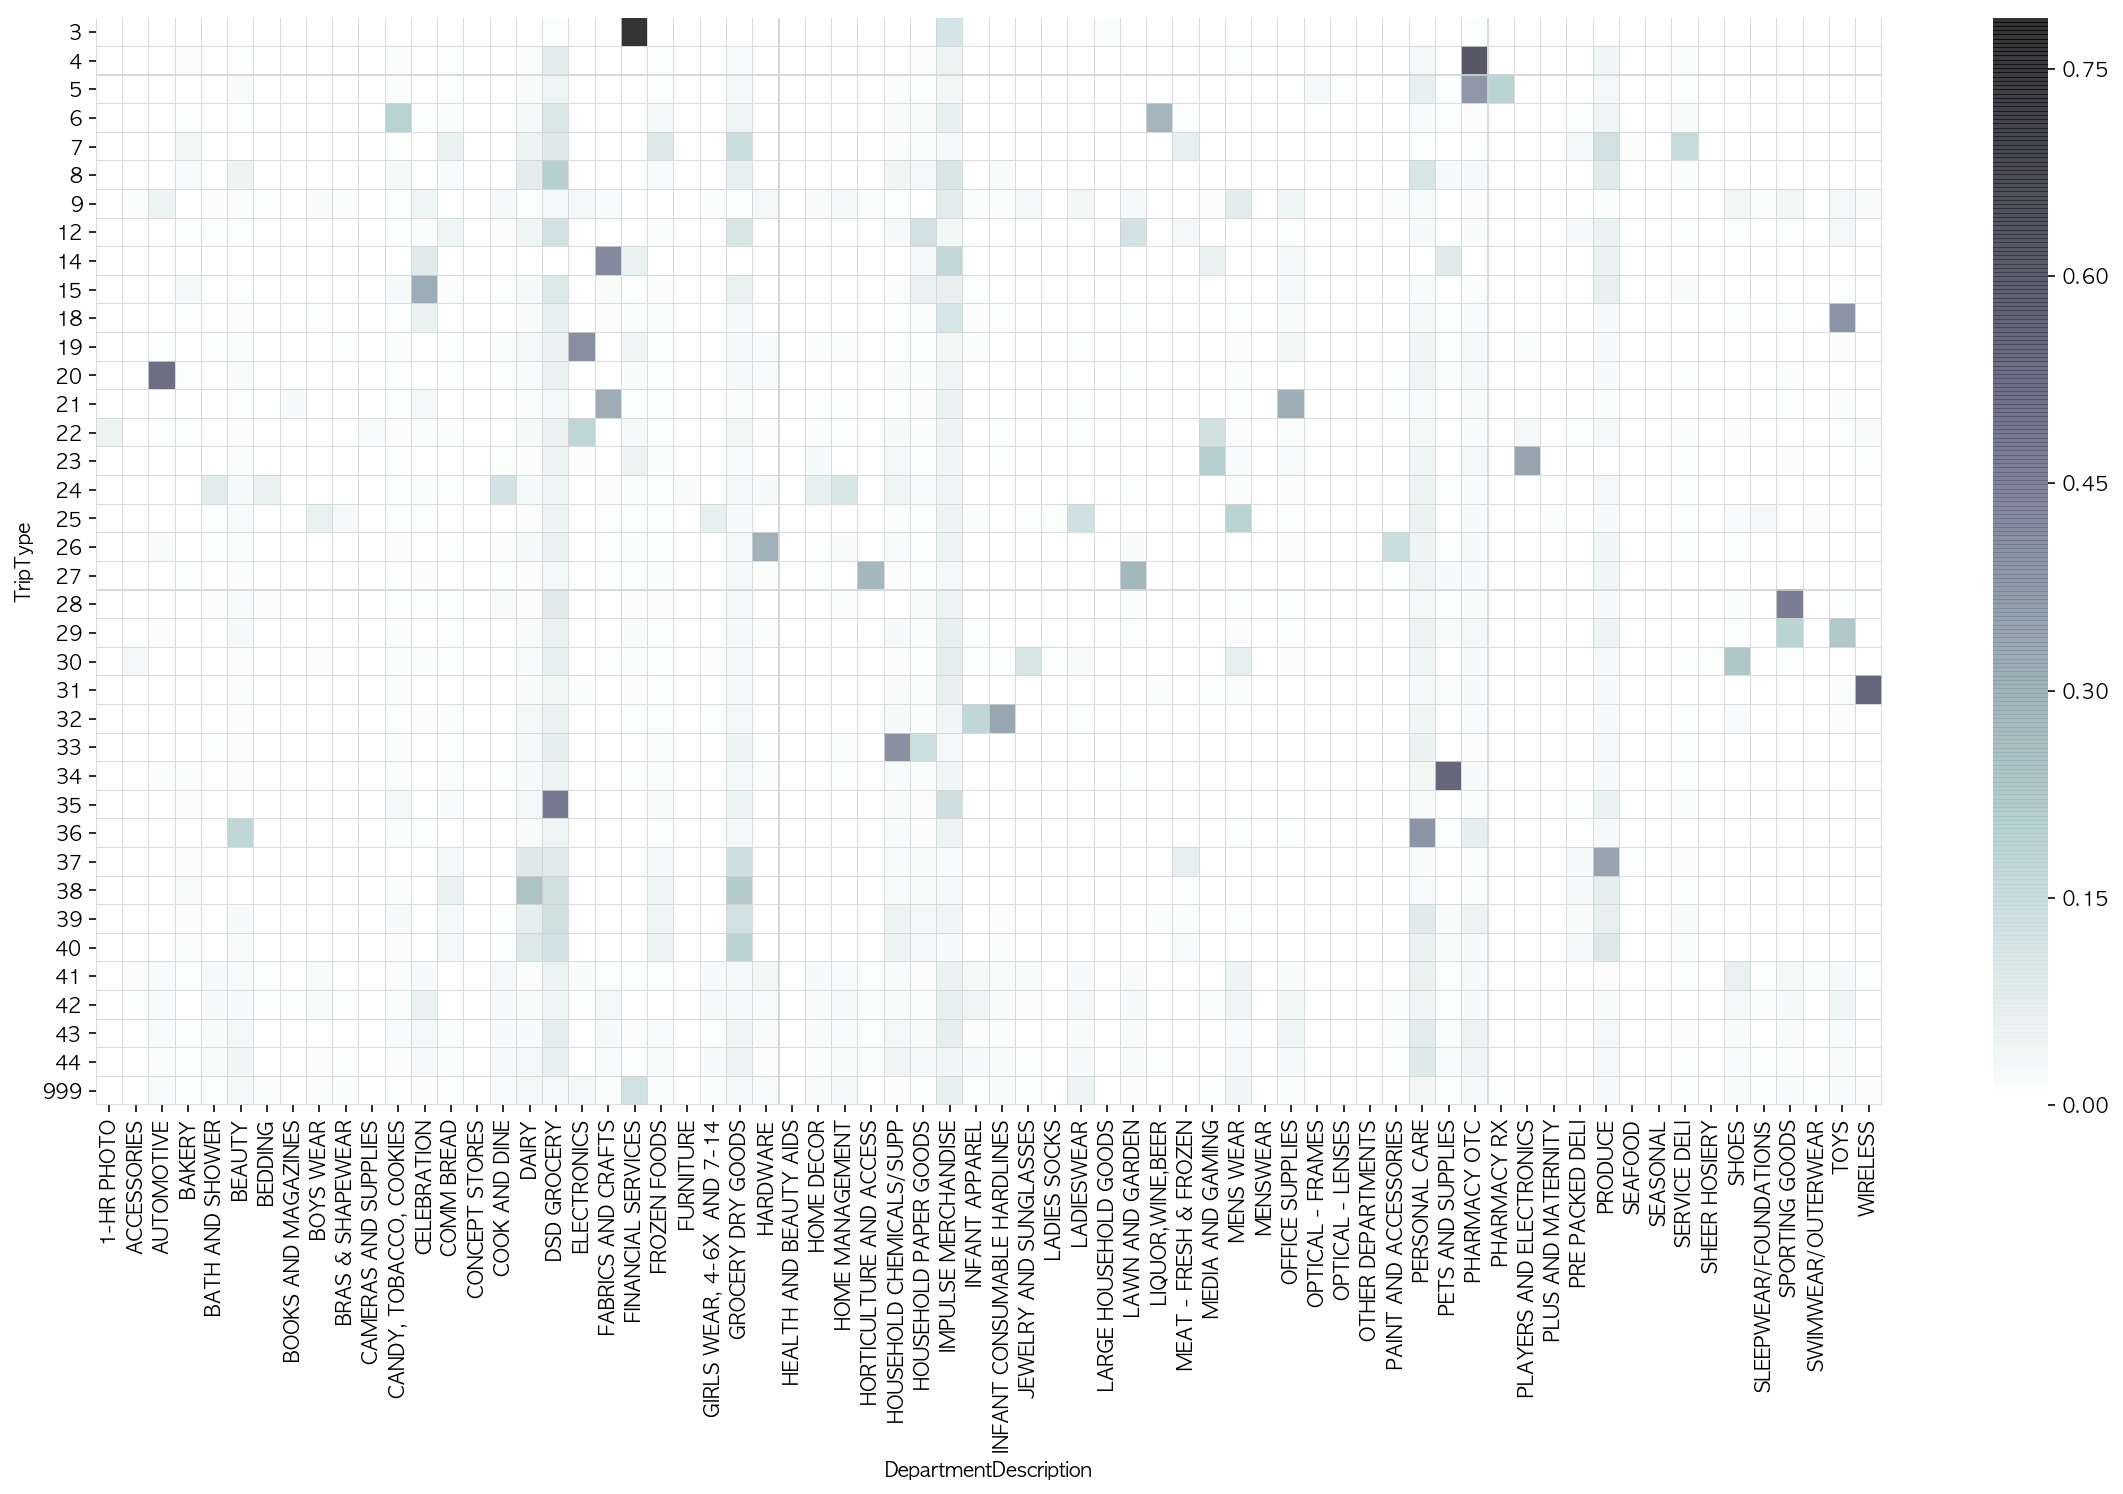

In [10]:
trip_desc = pd.crosstab(train["TripType"], 
                        train["DepartmentDescription"], 
                        values=train["ScanCount"], 
                        aggfunc="count", 
                        normalize="index")

plt.figure(figsize=(20, 10))
sns.heatmap(trip_desc, linecolor="lightgrey", linewidths=0.02, cmap=plt.cm.bone_r, alpha=.8)

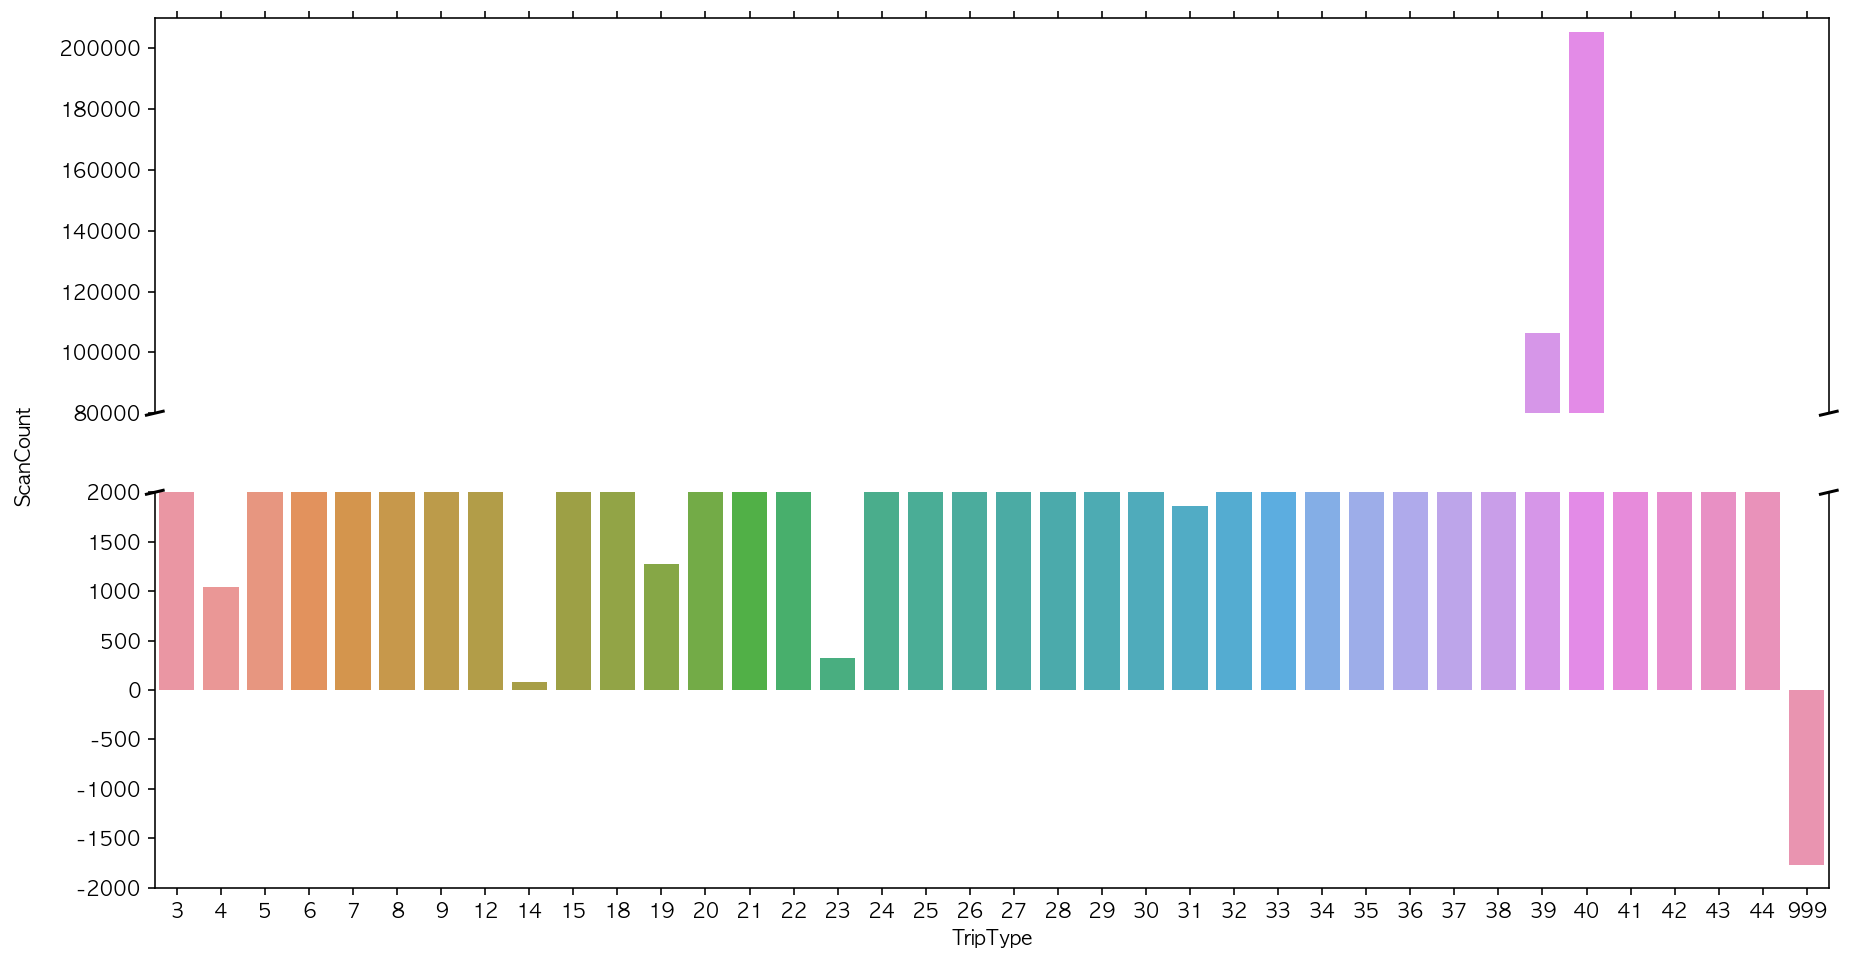

In [14]:
train_plot = train[["TripType", "ScanCount"]]
plot_grouped = train_plot.groupby("TripType", as_index=False).sum()

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
sns.barplot(x="TripType", y="ScanCount", data=plot_grouped, ax=ax)
sns.barplot(x="TripType", y="ScanCount", data=plot_grouped, ax=ax2)

ax.set_ylim(80000, 210000)  # outliers only
ax2.set_ylim(-2000, 2000)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
ax2.yaxis.label.set_visible(False)

f.text(0.06, 0.5, 'ScanCount', va='center', rotation='vertical')

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .005  # how big to make the diagonal lines in axes coordinates

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  

kwargs.update(transform=ax2.transAxes) 
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs) 

plt.show()

# [ Preprocessing ]

### UPC company code 분리

In [4]:
train["Upc"] = train.Upc.apply(float_to_str)
test["Upc"] = test.Upc.apply(float_to_str)

train["company"] = train.Upc.apply(company) 
test["company"] = test.Upc.apply(company)

In [5]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000.0,681131
1,30,7,Friday,60538815980,1,SHOES,8931.0,605388
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504.0,741081
3,26,8,Friday,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840
4,26,8,Friday,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661


### Return 발생 여부 표기

In [6]:
train.loc[train["ScanCount"] < 0, "Return"] = 1
train.loc[train["Return"] != 1, "Return"] = 0

test.loc[test["ScanCount"] < 0, "Return"] = 1
test.loc[test["Return"] != 1, "Return"] = 0

In [7]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0
1,30,7,Friday,60538815980,1,SHOES,8931.0,605388,0.0
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504.0,741081,0.0
3,26,8,Friday,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0
4,26,8,Friday,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0


### Weekday 인코딩

In [8]:
wd = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, 
      "Friday": 4, "Saturday": 5, "Sunday": 6}

train["Weekday"] = train["Weekday"].apply(lambda x: wd[x])
test["Weekday"] = test["Weekday"].apply(lambda x: wd[x])

In [9]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return
0,999,5,4,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0
1,30,7,4,60538815980,1,SHOES,8931.0,605388,0.0
2,30,7,4,7410811099,1,PERSONAL CARE,4504.0,741081,0.0
3,26,8,4,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0
4,26,8,4,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0


### 실제 판매 수량

In [10]:
train["Pos_Sum"] = train["ScanCount"]
test["Pos_Sum"] = test["ScanCount"]

train.loc[train["Pos_Sum"] < 0, "Pos_Sum"] = 0
test.loc[test["Pos_Sum"] < 0, "Pos_Sum"] = 0

In [11]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return,Pos_Sum
0,999,5,4,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0,0
1,30,7,4,60538815980,1,SHOES,8931.0,605388,0.0,1
2,30,7,4,7410811099,1,PERSONAL CARE,4504.0,741081,0.0,1
3,26,8,4,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0,2
4,26,8,4,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0,2


### 반품 수량

In [12]:
train["Neg_Sum"] = train["ScanCount"]
test["Neg_Sum"] = test["ScanCount"]

train.loc[train["Neg_Sum"] > 0, "Neg_Sum"] = 0
test.loc[test["Neg_Sum"] > 0, "Neg_Sum"] = 0

In [13]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return,Pos_Sum,Neg_Sum
0,999,5,4,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0,0,-1
1,30,7,4,60538815980,1,SHOES,8931.0,605388,0.0,1,0
2,30,7,4,7410811099,1,PERSONAL CARE,4504.0,741081,0.0,1,0
3,26,8,4,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0,2,0
4,26,8,4,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0,2,0


### UPC Check Digit 추가

In [14]:
train["check"] = train.Upc.apply(check_digit)
test["check"] = test.Upc.apply(check_digit)

In [15]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,company,Return,Pos_Sum,Neg_Sum,check
0,999,5,4,68113152929,-1,FINANCIAL SERVICES,1000.0,681131,1.0,0,-1,7
1,30,7,4,60538815980,1,SHOES,8931.0,605388,0.0,1,0,9
2,30,7,4,7410811099,1,PERSONAL CARE,4504.0,741081,0.0,1,0,2
3,26,8,4,2238403510,2,PAINT AND ACCESSORIES,3565.0,223840,0.0,2,0,2
4,26,8,4,2006613744,2,PAINT AND ACCESSORIES,1017.0,200661,0.0,2,0,1


# [ Feature Engineering ]

### VisitNumber 별 가장 빈도가 잦은 FinelineNumber

In [21]:
# new feature

train_fineline = train[["VisitNumber", "FinelineNumber"]]
train_fineline = train_fineline.groupby("VisitNumber", as_index=False).agg(mode)
train_fineline.rename(columns={"FinelineNumber": "MF_FinelineNumber"}, inplace=True)

test_fineline = test[["VisitNumber", "FinelineNumber"]]
test_fineline = test_fineline.groupby("VisitNumber", as_index=False).agg(mode)
test_fineline.rename(columns={"FinelineNumber": "MF_FinelineNumber"}, inplace=True)

### VisitNumber 별 

In [ ]:
train_upc_fine = train[["VisitNumber", "Upc", "FinelineNumber"]]
test_upc_fine = test[["VisitNumber", "Upc", "FinelineNumber"]]

train_upc_fine_group = train_upc_fine.groupby("VisitNumber", as_index=False).count()
train_upc_fine_group.rename(columns={"Upc": "N_Upc", 
                                     "FinelineNumber": "N_FinelineNumber"}, inplace=True)
test_upc_fine_group = test_upc_fine.groupby("VisitNumber", as_index=False).count()
test_upc_fine_group.rename(columns={"Upc": "N_Upc", 
                                    "FinelineNumber": "N_FinelineNumber"}, inplace=True)

In [ ]:
train_upc_fine_group.head()

In [ ]:
train = train.drop(["Upc", "FinelineNumber"], axis=1)
test = test.drop(["Upc", "FinelineNumber"], axis=1)

### DepartmentDescription의 더미변수 생성

In [ ]:
train_dd = pd.get_dummies(train["DepartmentDescription"])
test_dd = pd.get_dummies(test["DepartmentDescription"])

train_dd = pd.concat([train[["VisitNumber"]], train_dd], axis=1)
test_dd = pd.concat([test[["VisitNumber"]], test_dd], axis=1)

train_dd = train_dd.groupby("VisitNumber", as_index=False).sum()
test_dd = test_dd.groupby("VisitNumber", as_index=False).sum()

In [ ]:
train_dd.head()

### 각 VisitNumber별 가장 많이 구매한 제품의 기업 코드

In [ ]:
train_company = train[["VisitNumber", "company"]]
test_company = test[["VisitNumber", "company"]]

train_company = train_company.groupby("VisitNumber", as_index=False).agg(mode)
test_company = test_company.groupby("VisitNumber", as_index=False).agg(mode)

In [ ]:
train_company.head()

### 각 VisitNumber 별 가장 많이 구매한 제품의 Check Digit

In [ ]:
train_check = train[["VisitNumber", "check"]]
test_check = test[["VisitNumber", "check"]]

train_check = train_check.groupby("VisitNumber", as_index=False).agg(mode)
test_check = test_check.groupby("VisitNumber", as_index=False).agg(mode)

In [ ]:
train_check.head()

### VisitNumber를 index로 하는 groupby & merge

In [ ]:
train_by_sum = train[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]
test_by_sum = test[["VisitNumber", "ScanCount", "Pos_Sum", "Neg_Sum"]]

train_by_sum = train_by_sum.groupby("VisitNumber", as_index=False).sum()
test_by_sum = test_by_sum.groupby("VisitNumber", as_index=False).sum()

train_by_max = train[["TripType", "VisitNumber", "Weekday", "Return"]]
test_by_max = test[["VisitNumber", "Weekday", "Return"]]

train_by_max = train_by_max.groupby("VisitNumber", as_index=False).max()
test_by_max = test_by_max.groupby("VisitNumber", as_index=False).max()

In [ ]:
train = train_by_sum.merge(train_by_max, on=["VisitNumber"])
train = train.merge(train_dd, on=["VisitNumber"])
train = train.merge(train_company, on=["VisitNumber"])
train = train.merge(train_check, on=["VisitNumber"])
train = train.merge(train_fineline, on=["VisitNumber"])
train = train.merge(train_upc_fine_group, on=["VisitNumber"])

test = test_by_sum.merge(test_by_max, on=["VisitNumber"])
test = test.merge(test_dd, on=["VisitNumber"])
test = test.merge(test_company, on=["VisitNumber"])
test = test.merge(test_check, on=["VisitNumber"])
test = test.merge(test_fineline, on=["VisitNumber"])
test = test.merge(test_upc_fine_group, on=["VisitNumber"])

In [ ]:
train['MF_']

- ### test data에서는 발생하지 않는 DepartmentDescription 제거
- ### train & target 분리

In [ ]:
y = train["TripType"]
train = train.drop(["TripType", "HEALTH AND BEAUTY AIDS"], axis=1)

### 각 VisitNumber 별 판매된 아이템의 DepartmentDescription 빈도

In [ ]:
from walmart_utils import category_counts

In [ ]:
%%time
train = category_counts(train)
test = category_counts(test)

In [ ]:
train.head()

### VisitNumber 별로 발생한 FinelineNumber와 UPC의 비율

In [ ]:
train["Upc_FLN"] = train["N_Upc"] / train["N_FinelineNumber"]
test["Upc_FLN"] = test["N_Upc"] / test["N_FinelineNumber"]

In [ ]:
train.head()

### Weeday, Return의 더미변수 생성

In [ ]:
train = pd.get_dummies(train, columns=["Weekday", "Return"])
test = pd.get_dummies(test, columns=["Weekday", "Return"])

In [ ]:
train.head()

In [ ]:
train[np.isnan(train['MF_FinelineNumber']) == True]['MF_FinelineNumber'].unique()

### Null Value, Inf Value

In [ ]:
train.replace(np.inf, 0, inplace=True)
train.fillna(value=0, inplace=True)

test.replace(np.inf, 0, inplace=True)
test.fillna(value=0, inplace=True)

* * * *

# [ Model Generation ]

- XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_enc = LabelEncoder().fit(y)
y_labeled = label_enc.transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train, y_labeled, random_state=0)

In [ ]:
dtrain = xgb.DMatrix(X_train.values, label=y_train)
dtest = xgb.DMatrix(X_test.values, label=y_test)

In [ ]:
num_boost_round = 300
params = {'objective': 'multi:softprob', 
          'eval_metric': 'mlogloss',
          'num_class':38, 
          'max_delta_step': 3, 
          'eta': 0.25}

evals = [(dtrain, 'train'), (dtest, 'eval')]


bst = xgb.train(params=params,  
                dtrain=dtrain, 
                num_boost_round=num_boost_round, 
                evals=evals,
                early_stopping_rounds=10,)

In [ ]:
classes = np.array(list(set(label_enc.inverse_transform(y_labeled))))

In [ ]:
dmtest = xgb.DMatrix(test.values) 
pred_proba = bst.predict(dmtest)

proba_df = pd.DataFrame(pred_proba, columns=classes)
proba_df.columns = proba_df.columns.map(lambda x: "TripType_" + str(x))
sub_df = pd.concat([test[["VisitNumber"]], proba_df], axis=1)
sub_df.to_csv("data/team_SWYA_submission.csv", index=False)